In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Подгрузка данных

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
# Зафиксируем константы
INPUT_DIR = '/kaggle/input/sf-booking/'
RANDOM_STATE = 42


In [5]:
# загружаем данные из соревнования
df_train = pd.read_csv(INPUT_DIR + 'hotels_train.csv')
df_test = pd.read_csv(INPUT_DIR + 'hotels_test.csv')
submission = pd.read_csv(INPUT_DIR + 'submission.csv')



# Обзор данных

Первоначальная версия датасета содержит 17 полей со следующей информацией:

* ***hotel_address*** — адрес отеля;
* ***review_date*** — дата, когда рецензент разместил соответствующий отзыв;
* ***average_score*** — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
* ***hotel_name*** — название отеля;
* ***reviewer_nationality*** — страна рецензента;
* ***negative_review*** — отрицательный отзыв, который рецензент дал отелю;
* ***review_total_negative_word_counts*** — общее количество слов в отрицательном отзыв;
* ***positive_review*** — положительный отзыв, который рецензент дал отелю;
* ***review_total_positive_word_counts*** — общее количество слов в положительном отзыве.
* ***reviewer_score*** — оценка, которую рецензент поставил отелю на основе своего опыта;
* ***total_number_of_reviews_reviewer_has_given*** — количество отзывов, которые рецензенты дали в прошлом;
* ***total_number_of_reviews*** — общее количество действительных отзывов об отеле;
* ***tags*** — теги, которые рецензент дал отелю;
* ***days_since_review*** — количество дней между датой проверки и датой очистки;
* ***additional_number_of_scoring*** — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
* ***lat*** — географическая широта отеля;
* ***lng*** — географическая долгота отеля.

Для обучения модели датасет разделен на две части: тренировочный и тестовый, тестовый датасет содержит число полей на один меньше чем тренировочный, в нем нет признака reviewer_score, признак которого должна предсказать модель. Также есть шаблон-датасет submission, в котором принимаются результаты предсказания модели в данном соревновании. Рассмотрим эти датасеты детальнее.

In [6]:
# Посмотрим на таблицы
df_train.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [9]:
submission.head(3)

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688


In [10]:
submission.shape

(128935, 2)

## Разбор категорий

In [11]:
cat_columns = [col for col in df_train.columns if df_train[col].dtype == 'object']
print(len(cat_columns))
cat_columns


8


['hotel_address',
 'review_date',
 'hotel_name',
 'reviewer_nationality',
 'negative_review',
 'positive_review',
 'tags',
 'days_since_review']

Из 17 признаков тренировочного датасета (hotels_train) 9 числовых, один из которых является целевым признаком, 8 категориальных, среди которых есть один признак времени 'review_date', его переведем в соответствующий тип данных Timestamp. В тестовом датасете hotels_test 16 признаков, распределение типов признаков аналогичное, за исключением целевого признака, он отсутствует в тестовом датасете.

# Очистка данных от дубликатов и пропущенных значений

Так как число строк в тестовом датасете не должно меняться, очищаем от дубликатов только тренировочный датасет.

In [12]:
print(f'Число дубликатов в тренировочной выборке: {df_train.duplicated().sum()}')
df_train = df_train.drop_duplicates()
print('Число строк после удаления дубликатов: {}'.format(df_train.shape[0]))

Число дубликатов в тренировочной выборке: 307
Число строк после удаления дубликатов: 386496


In [13]:
# дря корректной обработки признаков объединяем тренировочный  и тестовый датасеты в один датасет

df_train['sample'] = 1 # помечаем где трейн-данные
df_test['sample'] = 0 # помечаем где тест-данные
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

hotels = pd.concat([df_train, df_test], ignore_index = True) # объединяем датасеты
hotels.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,sample
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671,1
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097,1
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643,1


In [14]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

In [15]:
# Для заполнения пропусков в признаках 'lat' и 'lng' найдем уникальное число отелей с пропусками в этих признаках
w_nulls = list(hotels[hotels.isna().any(axis=1)]['hotel_name'].unique())
print(len(w_nulls))
w_nulls

17


['Austria Trend Hotel Schloss Wilhelminenberg Wien',
 'Holiday Inn Paris Montmartre',
 'Fleming s Selection Hotel Wien City',
 'Hotel Atlanta',
 'Maison Albar Hotel Paris Op ra Diamond',
 'Derag Livinghotel Kaiser Franz Joseph Vienna',
 'Hotel City Central',
 'NH Collection Barcelona Podium',
 'City Hotel Deutschmeister',
 'Hotel Daniel Vienna',
 'Roomz Vienna',
 'Hotel Pension Baron am Schottentor',
 'Mercure Paris Gare Montparnasse',
 'Hotel Park Villa',
 'Hotel Advance',
 'Renaissance Barcelona Hotel',
 'Cordial Theaterhotel Wien']

In [16]:
# Координаты отелей с пропусками найдены с помощью Google Maps
coords_na ={
    'Fleming s Selection Hotel Wien City':[48.209095, 16.354568],
    'Hotel City Central':[48.213560, 16.379923],
    'Hotel Atlanta':[48.220310, 16.355880],
    'Maison Albar Hotel Paris Op ra Diamond':[48.875140, 2.323420],
    'Hotel Daniel Vienna':[48.188835, 16.383810],
    'Hotel Pension Baron am Schottentor':[48.216705, 16.359820],
    'Austria Trend Hotel Schloss Wilhelminenberg Wien':[48.219555, 16.285566],
    'NH Collection Barcelona Podium':[41.391430, 2.177890],
    'Derag Livinghotel Kaiser Franz Joseph Vienna':[48.245914, 16.341188],
    'City Hotel Deutschmeister':[48.220856, 16.366642],
    'Holiday Inn Paris Montmartre':[48.888860, 2.333190],
    'Hotel Park Villa':[48.233495, 16.345556],
    'Cordial Theaterhotel Wien':[48.209530, 16.351515],
    'Roomz Vienna':[48.22201, 16.39331],
    'Mercure Paris Gare Montparnasse':[48.839701, 2.323519],
    'Hotel Advance':[41.38322, 2.16295],
    'Renaissance Barcelona Hotel':[41.392430, 2.167500]
}

In [17]:
# В цикле заполним пропуски в признаке 'lat' и 'lng' датасета hotels

hotels['lat'] = hotels.apply(lambda row: coords_na[row['hotel_name']][0] if row['hotel_name'] in coords_na else row['lat'], axis=1)
hotels['lng'] = hotels.apply(lambda row: coords_na[row['hotel_name']][1] if row['hotel_name'] in coords_na else row['lng'], axis=1)
print(hotels['lat'].isna().any())# проверим остались ли строки с пропусками в признаке 'lat'
print(hotels['lng'].isna().any())# проверим остались ли строки с пропусками в признаке 'lng'


False
False


In [18]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

Фрейм данных очищен от пропусков.

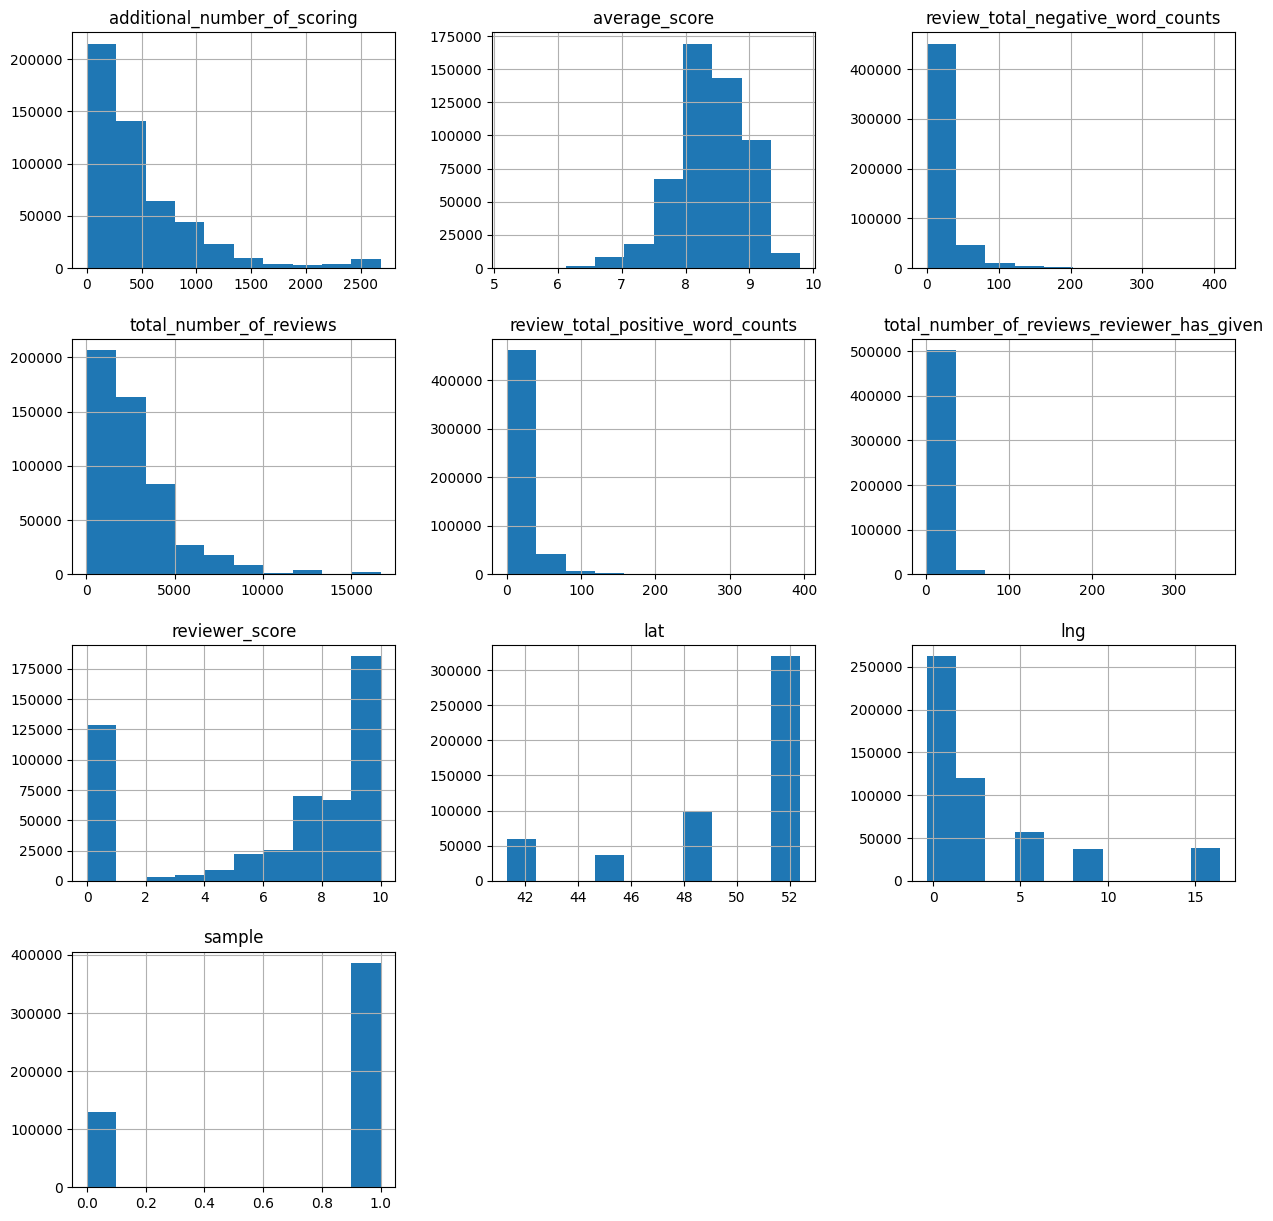

In [26]:
fig = hotels.hist(figsize = (15,15))
plt.show();

Отметим, что ни один числовой признак не распределен нормально.

# Преобразование признаков.

Посмотрим на список категориальных признаков, и начнем разбирать их.

In [ ]:
# выведем на печать список категориальных признаков
import pprint
pprint.pprint(cat_columns)

['hotel_address',
 'review_date',
 'hotel_name',
 'reviewer_nationality',
 'negative_review',
 'positive_review',
 'tags',
 'days_since_review']


## Начнём с временного  признака - дата размещения отзыва - 'review_date'

In [ ]:
# Признак 'review_date' временной признак, однако значения в признаке имеют другой тип данных
print(hotels.loc[3,'review_date'])# возьмём любое значение из столбца, например 3-й по индексу
print(type(hotels.loc[3,'review_date']))# узнаем тип данных значения в признаке 'review_date'

9/22/2015
<class 'str'>


In [ ]:
# Переведём значения данного признака в тип данных Timestamp
hotels['review_date'] = pd.to_datetime(hotels['review_date'])
print(hotels.loc[3,'review_date'])
print(type(hotels.loc[3,'review_date']))# Проверим снова тип данных

2015-09-22 00:00:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


## Следующий признак - количество дней между датой проверки и датой очистки - 'days_since_review'

In [ ]:
# Признак 'days_since_review' это количество дней между датой проверки и датой очистки, 
# и его значения даны в типе строка, переведем их в числовой тип.
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda days: int(days.split()[0]))
hotels['days_since_review']


0         531
1         203
2         289
3         681
4         516
         ... 
515426    547
515427    411
515428     28
515429    586
515430    589
Name: days_since_review, Length: 515431, dtype: int64

In [ ]:
hotels.describe(include=(object))

,hotel_address,hotel_name,reviewer_nationality,negative_review,positive_review,tags
count,515431,515431,515431,515431,515431,515431
unique,1493,1492,227,330011,412601,55242
top,163 Marsh Wall Docklands Tower Hamlets London E14 9SJ United Kingdom,Britannia International Hotel Canary Wharf,United Kingdom,No Negative,No Positive,"[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']"
freq,4789,4789,245165,127816,35924,5101


## Следующий категориальный признак - признак адресов отелей - 'hotel_address'

Текущий формат адресов в датасете неинформативен, так как уникальных значений в признаке 

In [ ]:
# Посмотрим на формат значений в признаке адресов отелей.
address = pd.DataFrame(hotels['hotel_address'])
pd.set_option('max_colwidth', 200)# задаём ширину столбца для полного отображения строковых значений в признаке
address.head(10)

,hotel_address
0,Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom
1,130 134 Southampton Row Camden London WC1B 5AF United Kingdom
2,151 bis Rue de Rennes 6th arr 75006 Paris France
3,216 Avenue Jean Jaures 19th arr 75019 Paris France
4,Molenwerf 1 1014 AG Amsterdam Netherlands
5,Via Mecenate 121 20138 Milan Italy
6,97 Cromwell Road Kensington and Chelsea London SW7 4DN United Kingdom
7,Josefsgasse 4 6 08 Josefstadt 1080 Vienna Austria
8,190 Queen s Gate Kensington and Chelsea London SW7 5EX United Kingdom
9,Holland Park Avenue Kensington and Chelsea London W11 4UL United Kingdom


In [ ]:
print(f'Число уникальных значений признака адресов отелей: {hotels["hotel_address"].nunique()},')
print(f'\nчто составляет {round(((hotels["hotel_address"].nunique()/hotels.shape[0])*100),2)}% от общего числа записей в датасете')

Число уникальных значений признака адресов отелей: 1493,

что составляет 0.29% от общего числа записей в датасете


Несмотря на то, что число уникальных адресов составляет очень маленькую долю общего числа записей в датасете, их очень много (1493). При кодировании такого признака даже бинарным кодом, число признаков существенно увеличится, что негативно повлияет на скорость обучения модели. По этому из адресов отелей получим города и создадим новый признак с более меньшим числом уникальных значений.

In [ ]:
hotels['city'] = hotels['hotel_address'].apply(lambda address: address.strip().split()[-5] if address.split()[-1] == 'Kingdom' else address.split()[-2])
hotels['city'].value_counts()

London       262300
Barcelona     60149
Paris         59626
Amsterdam     57212
Vienna        38938
Milan         37206
Name: city, dtype: int64

Получили новый признак из 6 значений, теперь признак 'hotel_address' можем удалить.

In [ ]:
hotels = hotels.drop(['hotel_address'], axis=1)
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   additional_number_of_scoring                515431 non-null  int64         
 1   review_date                                 515431 non-null  datetime64[ns]
 2   average_score                               515431 non-null  float64       
 3   hotel_name                                  515431 non-null  object        
 4   reviewer_nationality                        515431 non-null  object        
 5   negative_review                             515431 non-null  object        
 6   review_total_negative_word_counts           515431 non-null  int64         
 7   total_number_of_reviews                     515431 non-null  int64         
 8   positive_review                             515431 non-null  object       

Посмотрим на оставшиеся категориальные признаки.

In [ ]:
hotels.describe(include = (object))

,hotel_name,reviewer_nationality,negative_review,positive_review,tags,city
count,515431,515431,515431,515431,515431,515431
unique,1492,227,330011,412601,55242,6
top,Britannia International Hotel Canary Wharf,United Kingdom,No Negative,No Positive,"[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']",London
freq,4789,245165,127816,35924,5101,262300


## Разберемся с очередным признаком наименований отелей - 'hotel_name'

In [ ]:
# Разберемся с признаком 'hotel_name'
hotels['hotel_name'].value_counts()

Britannia International Hotel Canary Wharf           4789
Strand Palace Hotel                                  4256
Park Plaza Westminster Bridge London                 4169
Copthorne Tara Hotel London Kensington               3578
DoubleTree by Hilton Hotel London Tower of London    3212
                                                     ... 
Boundary Rooms Suites                                  12
Le Lavoisier                                           12
Hotel Wagner                                           10
Mercure Paris Porte d Orleans                          10
Hotel Gallitzinberg                                     8
Name: hotel_name, Length: 1492, dtype: int64

In [ ]:
# Проверим какое слово чаще встречается в названиях отелей
words_in_name = hotels['hotel_name'].apply(lambda name: name.lower().strip().split())
words_in_name = words_in_name.explode(ignore_index = True)
words_in_name = pd.DataFrame(words_in_name)



In [ ]:
words_in_name['hotel_name'].value_counts(normalize = True).round(2).nlargest(30)

hotel         0.12
london        0.07
the           0.03
park          0.02
amsterdam     0.02
hilton        0.02
by            0.01
plaza         0.01
paris         0.01
grand         0.01
inn           0.01
kensington    0.01
barcelona     0.01
city          0.01
doubletree    0.01
best          0.01
western       0.01
holiday       0.01
tel           0.01
h             0.01
a             0.01
de            0.01
palace        0.01
s             0.01
hyde          0.01
st            0.01
vienna        0.01
wien          0.01
radisson      0.01
blu           0.01
Name: hotel_name, dtype: float64

Среди названий есть некоторые слова, по к-м можно классифицировать сами отели. Например: *hotel*, *park*, *club* и т.д.

Составим список таких слов. Это будут виды отелей.

In [ ]:
type_of_hotels = ['hotel','park', 'hilton', 'palace', 'plaza', 'grand', 'club']

Создадим новый признак 'type_of_hotel'

In [ ]:
def get_type_of_hotels(name):
    
    """Функция для преобразования признака - Тип отеля"""
    
    name = name.lower().strip().split()
    for type in type_of_hotels:
        if type in name:
            return type
    return 'unknown' # остальные отели, не попавшие в список
    
hotels['type_of_hotel'] = hotels['hotel_name'].apply(get_type_of_hotels)
hotels['type_of_hotel'].value_counts()

hotel      232914
unknown    201286
park        35318
hilton      27677
plaza        7864
palace       6445
grand        2183
club         1744
Name: type_of_hotel, dtype: int64

Образовался новый признак из 8 уникальных значений. Теперь сам признак 'hotel_name' не нужен, его удалим в целях сократить число признаков в датасете.

In [ ]:
hotels = hotels.drop(['hotel_name'], axis=1)

In [ ]:
hotels.describe(include=(object))

,reviewer_nationality,negative_review,positive_review,tags,city,type_of_hotel
count,515431,515431,515431,515431,515431,515431
unique,227,330011,412601,55242,6,8
top,United Kingdom,No Negative,No Positive,"[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']",London,hotel
freq,245165,127816,35924,5101,262300,232914


## Разберем признак национальности рецензентов.

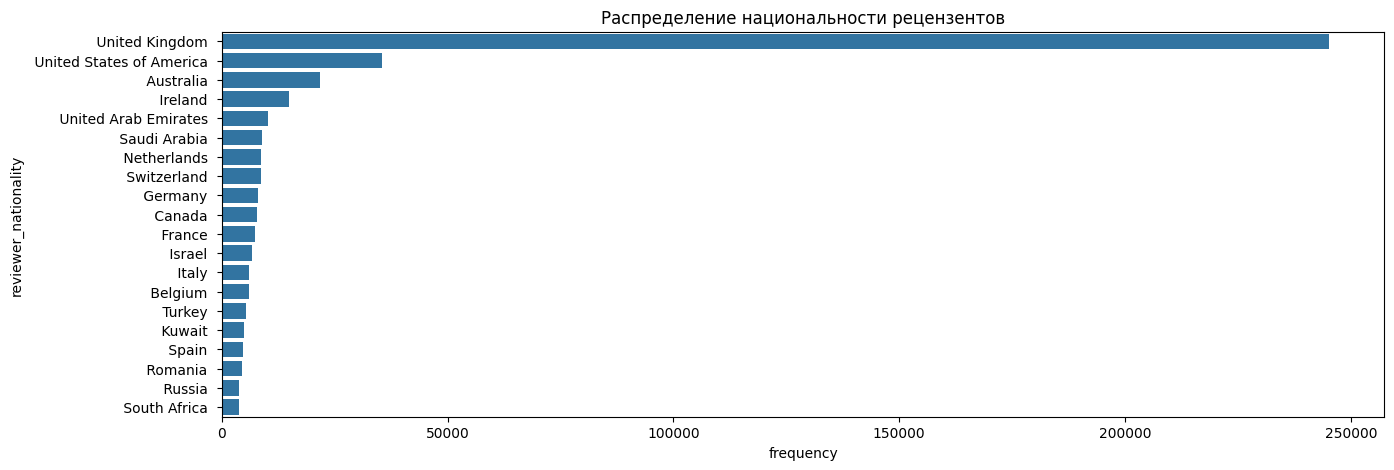

In [28]:
reviewer_nationality = hotels['reviewer_nationality'].value_counts().nlargest(20)
reviewer_nationality = pd.DataFrame({'reviewer_nationality': reviewer_nationality.index,
                                    'frequency': reviewer_nationality.values})
fig, ax = plt.subplots(figsize = (15,5))
sns.barplot(reviewer_nationality, x='frequency', y='reviewer_nationality', ax=ax)
ax.set_title("Распределение национальности рецензентов")

plt.show()

Уникальных значений в данном признаке 227, посмотрим сколько признаков  создадутся при бинарном кодировании данного признака.

In [ ]:
! pip install category_encoders

In [ ]:
print(f'Число признаков до кодирования признака национальности рецензентов: {hotels.shape[1]}')
import category_encoders as ce
bin_encoder = ce.BinaryEncoder(cols = ['reviewer_nationality']) 
df_bin = bin_encoder.fit_transform(hotels['reviewer_nationality'])
hotels = pd.concat([hotels, df_bin], axis=1)
print(f'Число призаков после кодировки данного признака: {hotels.shape[1]}')

Число признаков до кодирования признака национальности рецензентов: 18
Число призаков после кодировки данного признака: 26


Число признаков увеличилось на 8, при преобразовании данного признака путем отбора топ значений и назначением остальных как other, и кодировании через One Hot encoder, число признаков увеличилось бы на 6-8. Так как рост числа признаков в обоих вариантах одинаков, кодируем признак без преобразований.

In [ ]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 26 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   additional_number_of_scoring                515431 non-null  int64         
 1   review_date                                 515431 non-null  datetime64[ns]
 2   average_score                               515431 non-null  float64       
 3   reviewer_nationality                        515431 non-null  object        
 4   negative_review                             515431 non-null  object        
 5   review_total_negative_word_counts           515431 non-null  int64         
 6   total_number_of_reviews                     515431 non-null  int64         
 7   positive_review                             515431 non-null  object        
 8   review_total_positive_word_counts           515431 non-null  int64        

In [ ]:
# Сам признак теперь не нужен, удаляем его
hotels = hotels.drop(['reviewer_nationality'], axis=1)

Посмотрим на оставшиеся категориальные признаки

In [ ]:
hotels.describe(include=(object))

,negative_review,positive_review,tags,city,type_of_hotel
count,515431,515431,515431,515431,515431
unique,330011,412601,55242,6,8
top,No Negative,No Positive,"[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']",London,hotel
freq,127816,35924,5101,262300,232914


## Разберем признаки отрицательных и положительных отзывов.

*Для выжимки из текстовых отзывов рецензентов используем бибилиотеку SentimentIntensityAnalyzer из модуля NLTK, которая возвращает число с плавающей точкой определяющее уровень настроения на основе входного текста. Положительные значения имеют положительную валентность, отрицательные значения — отрицательную валентность.*

In [ ]:
# Загружаем бибилиотеки
!pip install twython
!pip install nltk

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
nltk.downloader.download('vader_lexicon') 

sent_analyzer = SentimentIntensityAnalyzer()




[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Mira\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
# Используем метод polarity_scores для анализа тональности негативных и позитивных отзывов. 
# Результаты запишем в столбцы neg_sent и pos_sent.  

hotels['neg_sent'] = hotels['negative_review'].apply(lambda rev: sent_analyzer.polarity_scores(rev))
hotels['pos_sent'] = hotels['positive_review'].apply(lambda rev: sent_analyzer.polarity_scores(rev))

# Для того, чтобы эту информацию можно 
# было использовать в обучении модели, создадим отдельные признаки со значениями neg, neu, pos 
# и compound, которые определяют степень отрицательности, нейтральности, положительности и 
# общую тональность текста соответственно:

hotels['neg_neg_sent'] = hotels['neg_sent'].apply(lambda x: x['neg'])
hotels['neu_neg_sent'] = hotels['neg_sent'].apply(lambda x: x['neu'])
hotels['pos_neg_sent'] = hotels['neg_sent'].apply(lambda x: x['pos'])
hotels['compnd_neg_sent'] = hotels['neg_sent'].apply(lambda x: x['compound'])

hotels['neg_pos_sent'] = hotels['pos_sent'].apply(lambda x: x['neg'])
hotels['neu_pos_sent'] = hotels['pos_sent'].apply(lambda x: x['neu'])
hotels['pos_pos_sent'] = hotels['pos_sent'].apply(lambda x: x['pos'])
hotels['compnd_pos_sent'] = hotels['pos_sent'].apply(lambda x: x['compound'])

# Теперь признаки 'negative_review' и 'positive_review' нам не нужны, можем их удалить, 
# также новосозданные признаки 'neg_sent', 'pos_sent' тоже не нужны, так как со значениями 
# в виде словаря они неинформативны, и нужную информацию из этих признаков мы уже взяли
hotels = hotels.drop(columns = ['negative_review', 'positive_review', 'neg_sent', 'pos_sent'])
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 31 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   additional_number_of_scoring                515431 non-null  int64         
 1   review_date                                 515431 non-null  datetime64[ns]
 2   average_score                               515431 non-null  float64       
 3   review_total_negative_word_counts           515431 non-null  int64         
 4   total_number_of_reviews                     515431 non-null  int64         
 5   review_total_positive_word_counts           515431 non-null  int64         
 6   total_number_of_reviews_reviewer_has_given  515431 non-null  int64         
 7   reviewer_score                              515431 non-null  float64       
 8   tags                                        515431 non-null  object       

In [ ]:
hotels.describe(include = object)# посмотрим на оставшиеся категориальные признаки

,tags,city,type_of_hotel
count,515431,515431,515431
unique,55242,6,8
top,"[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']",London,hotel
freq,5101,262300,232914


## Разберем признак тегов, которые рецензент дал отелю.

Есть вероятность, что между количеством оставленных тэгов рецензентом и его оценкой есть связь, так как скорее всего много тэгов соспотавимо со множеством преимуществ отеля. По этому признка по количеству тэгов будет информативным для модели.

In [ ]:
# Создадим признак - количество тегов, которые рецензент дал отелю:

# Для начала преобразуем признак tags в список:

def lst_tags(tags):
    tags = tags[2:-2]
    res = tags.strip().split(' \', \' ')
    return res

hotels['tags_lst'] = hotels['tags'].apply(lst_tags)

# Узнаем длину списков из тегов, это и будет количество тегов у отеля:

hotels['tags_counts'] = hotels['tags_lst'].apply(lambda x: len(x))
hotels['tags_counts'].to_frame()

,tags_counts
0,5
1,4
2,5
3,4
4,4
...,...
515426,4
515427,5
515428,4
515429,5


In [ ]:
# Посмотрим сколько уникальных тегов представлено в наборе данных:

hotels_copy = hotels.copy()
tags_list = hotels_copy['tags_lst'].explode('tags_lst')
print(tags_list.nunique())
tags_list.value_counts().head(30)

2428


Leisure trip                      417538
Submitted from a mobile device    307470
Couple                            252128
Stayed 1 night                    193568
Stayed 2 nights                   133850
Solo traveler                     108476
Stayed 3 nights                    95761
Business trip                      82884
Group                              65361
Family with young children         60989
Stayed 4 nights                    47777
Double Room                        35207
Standard Double Room               32247
Superior Double Room               31361
Family with older children         26334
Deluxe Double Room                 24812
Double or Twin Room                22393
Stayed 5 nights                    20826
Standard Double or Twin Room       17479
Classic Double Room                16877
Superior Double or Twin Room       13570
2 rooms                            12384
Stayed 6 nights                     9765
Standard Twin Room                  9745
Single Room     

По уникальным тэгам можно увидеть, какую информацию можно вытащить из данного признака:
* Было ли бронирование выполненно через мобильное устройство
* Цели визитов отдыхающих: коммандировки или отдых 
* К какой группе относятся отдыхающие: пара, один человек, группа людей, или семья с детьми
* Количество мест в номере (одноместный, двуместный ...) с уровнями стандарт, делюкс или представительский.

In [ ]:
# Создадим новый признак submitted from a mobile device - было ли выполнено бронирование с помощью
# мобильного устройства:

def tag_mob_func(tags_lst_col):
    for i in range(len(tags_lst_col)):
        if tags_lst_col[i] != 'Submitted from a mobile device':
            i += 1
        else:
            return 1
    return 0

hotels['submitted from a mobile device'] = hotels['tags_lst'].apply(tag_mob_func)
hotels['submitted from a mobile device'].value_counts()

1    307470
0    207961
Name: submitted from a mobile device, dtype: int64

In [ ]:
# Создадим признаки цели визитов - отдыха (leisure trip purpose) и коммандировки 
# (business trip purpose):

def leisure_trip_func(tags_lst_col):
    for tag in tags_lst_col:
        if tag != 'Leisure trip':
            continue
        else:
            return 1
    return 0

hotels['business trip purpose'] = hotels['tags_lst'].apply(leisure_trip_func)
display(hotels['business trip purpose'].value_counts())


def business_trip_func(tags_lst_col):
    for tag in tags_lst_col:
        if tag != 'Business trip':
            continue
        else:
            return 1
    return 0

hotels['business trip purpose'] = hotels['tags_lst'].apply(business_trip_func)
display(hotels['business trip purpose'].value_counts())
        

1    417538
0     97893
Name: business trip purpose, dtype: int64

0    432547
1     82884
Name: business trip purpose, dtype: int64

В тэгах есть информация о том сколько ночей провели рецензенты в отели, и являются ли они парой или одиноким путешественником.
Также вытащим из тегов такие признаки как: количество проведенных ночей в отеле и отдыхающий (е) пара, одинокий путешественник, группа людей или семья с детьми.

In [ ]:
def get_night_cnt(tags_lst_col):
    for tag in tags_lst_col:
        if tag == 'Stayed 1 night':
            return 1
        elif tag == 'Stayed 2 nights':
            return 2
        elif tag == 'Stayed 3 nights':
            return 3
        elif tag == 'Stayed 4 nights':
            return 4
        elif tag == 'Stayed 5 nights':
            return 5
        elif tag == 'Stayed 6 nights':
            return 6
        elif tag == 'Stayed 7 nights':
            return 7
        else:
            continue
    return 0

hotels['nights_count'] = hotels['tags_lst'].apply(get_night_cnt)
display(hotels['nights_count'].value_counts())

print('\n')
def get_couple(tags_lst_col):
    for tag in tags_lst_col:
        if tag != 'Couple':
            continue
        else:
            return 1
    return 0

hotels['Couple'] = hotels['tags_lst'].apply(get_couple)
display(hotels['Couple'].value_counts())


print('\n')
def get_lone_traveler(tags_lst_col):
    for tag in tags_lst_col:
        if tag != 'Solo traveler':
            continue
        else:
            return 1
    return 0

hotels['Solo traveler'] = hotels['tags_lst'].apply(get_lone_traveler)
display(hotels['Solo traveler'].value_counts())


print('\n')
def get_group(tags_lst_col):
    for tag in tags_lst_col:
        if tag != 'Group':
            continue
        else:
            return 1
    return 0

hotels['Group'] = hotels['tags_lst'].apply(get_group)
display(hotels['Group'].value_counts())


print('\n')
def get_family(tags_lst_col):
    for tag in tags_lst_col:
        if (tag == 'Family with young children') or (tag == 'Family with older children'):
            return 1
        else:
            continue
    return 0

hotels['Family'] = hotels['tags_lst'].apply(get_family)
display(hotels['Family'].value_counts())

1    193568
2    133850
3     95761
4     47777
5     20826
6      9765
7      7391
0      6493
Name: nights_count, dtype: int64

0    263303
1    252128
Name: Couple, dtype: int64

0    406955
1    108476
Name: Solo traveler, dtype: int64

0    450070
1     65361
Name: Group, dtype: int64

0    428108
1     87323
Name: Family, dtype: int64

In [ ]:
# Так как количество признаков сильно увеличилось, 
# больше выжимать информацию из признака тэгов не будем, 
# то есть информацию по количеству комнат не будем брать, 
# так как  этот признак будет сильно коррелировать с признаками по количеству отдыхающих в номере.
# Удалим признак тэгов и новообразовавшийся признак со списком тэгов.
hotels = hotels.drop(columns = ['tags', 'tags_lst'])




In [ ]:
# Посмотрим на датафрейм hotels с новыми признаками:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 38 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   additional_number_of_scoring                515431 non-null  int64         
 1   review_date                                 515431 non-null  datetime64[ns]
 2   average_score                               515431 non-null  float64       
 3   review_total_negative_word_counts           515431 non-null  int64         
 4   total_number_of_reviews                     515431 non-null  int64         
 5   review_total_positive_word_counts           515431 non-null  int64         
 6   total_number_of_reviews_reviewer_has_given  515431 non-null  int64         
 7   reviewer_score                              515431 non-null  float64       
 8   days_since_review                           515431 non-null  int64        

## Настала очередь признака времени

В нашем датасете есть 2 признака, связанных с датой и временем: review_date и days_since_review. Взглянем на самую первую и последнюю дату в review_date.

In [ ]:
hotels['review_date'].sort_values()

367185   2015-08-04
9944     2015-08-04
370949   2015-08-04
371131   2015-08-04
481342   2015-08-04
            ...    
37761    2017-08-03
65006    2017-08-03
4068     2017-08-03
337838   2017-08-03
20000    2017-08-03
Name: review_date, Length: 515431, dtype: datetime64[ns]

03.08.2017 - самая свежая дата в наших данных, следовательно, мы можем считать актуальность данных именно по этому дню. Можно было бы рассчитать для каждого объекта разницу м/у этой датой и датой публикацией отзыва, но такой признак у нас уже есть: days_since_review, т.к. наша последняя дата полностью совпадает с датой выгрузки.

In [ ]:
hotels.loc[1, 'review_date'] + pd.to_timedelta(hotels.loc[1, 'days_since_review'], 'D') == pd.to_datetime('2017-08-03')

True

Таким образом "свежесть" отзыва у нас уже есть.

Но мы можем вытащить из review_date и другую информацию, а именно:

* year - год;
* quarter - квартал;
* month - месяц;
* weekday - день недели.

Информацию вытащим в строковом значении, так как в числовом значении, они воспримутся моделью как категориальные, однако эти признаки должны восприниматься как номинальные.

In [ ]:
hotels['year'] = hotels['review_date'].apply(lambda date: str(date.year))
hotels['quarter'] = hotels['review_date'].apply(lambda date: str(date.quarter))
hotels['month'] = hotels['review_date'].apply(lambda date: str(date.month))
hotels['weekday'] = hotels['review_date'].apply(lambda date: str(date.weekday()))

In [ ]:
# После того как получили всю необходимую информацию, признак review_date можно удалить
hotels = hotels.drop(['review_date'], axis=1)

In [ ]:
hotels.describe(include = (object))

,city,type_of_hotel,year,quarter,month,weekday
count,515431,515431,515431,515431,515431,515431
unique,6,8,3,4,12,7
top,London,hotel,2016,3,8,1
freq,262300,232914,264259,142292,50632,120882


Новообразовавшиеся все категориальные признаки являются номинальными, по этому кодируем их через OneHot Encoding

In [ ]:
nominal_cols = ['city', 'type_of_hotel', 'year', 'quarter', 'month', 'weekday']

In [ ]:
import category_encoders as ce
one_hot = ce.OneHotEncoder(cols = nominal_cols, use_cat_names =True)
one_hot_df = one_hot.fit_transform(hotels[nominal_cols])

hotels = pd.concat([hotels, one_hot_df], axis=1)


In [ ]:
hotels = hotels.drop(columns = nominal_cols)

In [ ]:
hotels.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,days_since_review,lat,lng,...,month_7,month_4,month_8,weekday_4,weekday_3,weekday_1,weekday_5,weekday_2,weekday_0,weekday_6
count,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,...,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000
mean,498.275079,8.397630,18.539760,2744.259084,17.777342,7.165215,6.296715,354.405492,49.432748,2.893772,...,0.095631,0.083177,0.098232,0.086725,0.144444,0.234526,0.100508,0.113610,0.157340,0.162846
std,500.618961,0.548033,29.690973,2317.823718,21.803204,11.038742,3.902967,208.915335,3.461232,4.668792,...,0.294084,0.276150,0.297629,0.281433,0.351540,0.423703,0.300677,0.317337,0.364122,0.369226
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,0.000000,0.000000,41.328376,-0.369758,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,0.000000,175.000000,48.214066,-0.143372,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,342.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,7.900000,353.000000,51.499981,0.019886,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,660.000000,8.800000,23.000000,3633.000000,22.000000,8.000000,9.600000,527.000000,51.516288,4.841163,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,10.000000,730.000000,52.400181,16.429233,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Нормализация данных

Наконец все признаки датафрейма приняли вид числовых признаков, теперь необходимо привести все наши признаки в подобающий для обучения вид.
Так как как мы изначально установили что все признаки распределены не нормально, воспользуемся нормализацией, а не стандартизацией. Также так как мы не очищали данные от выбросов, воспользуемся методом RobustScaler.

In [ ]:
# Для нормализации обозначим для начала числовые признаки, 
# изначально полученные в числовом виде, 
# кроме признаков, полученных путем кодирования, 
# их можно определить по максимальному значению,
# оно не должно быть равно 1, 
# исключением является признаки геоданных - 'lat' и 'lng', 
# а также признаки оценки рецензентов 'reviewer_score' и 'average_score',
# они тоже категориальные
num_cols = [col for col in hotels.columns if hotels[col].max() != 1]
num_cols.remove('reviewer_score')


print(len(num_cols))
num_cols

13


['additional_number_of_scoring',
 'average_score',
 'review_total_negative_word_counts',
 'total_number_of_reviews',
 'review_total_positive_word_counts',
 'total_number_of_reviews_reviewer_has_given',
 'days_since_review',
 'lat',
 'lng',
 'compnd_neg_sent',
 'compnd_pos_sent',
 'tags_counts',
 'nights_count']

In [ ]:
from sklearn import preprocessing

mm_scaler = preprocessing.MinMaxScaler()
mm_df = mm_scaler.fit_transform(hotels[num_cols])
mm_df = pd.DataFrame(mm_df, columns = num_cols)

hotels = hotels.drop(columns = num_cols)
hotels = pd.concat([hotels, mm_df], axis =1)

hotels.describe()

,reviewer_score,sample,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7,...,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,lng,compnd_neg_sent,compnd_pos_sent,tags_counts,nights_count
count,515431.000000,515431.00000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,...,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000
mean,6.296715,0.74985,0.003126,0.049013,0.185747,0.195555,0.262860,0.323258,0.184263,0.707132,...,0.162462,0.045006,0.017416,0.485487,0.731983,0.194269,0.395578,0.795358,0.713878,0.319875
std,3.902967,0.43310,0.055819,0.215896,0.388903,0.396628,0.440187,0.467721,0.387699,0.455079,...,0.139401,0.055198,0.031183,0.286185,0.312617,0.277921,0.227323,0.172722,0.104036,0.199519
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.067240,0.012658,0.000000,0.239726,0.621912,0.013476,0.144648,0.672787,0.600000,0.142857
50%,7.900000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.125759,0.027848,0.005650,0.483562,0.918694,0.023194,0.411231,0.853518,0.800000,0.285714
75%,9.600000,1.00000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,...,0.215914,0.055696,0.019774,0.721918,0.920167,0.310192,0.500426,0.941538,0.800000,0.428571
max,10.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Отбор признаков

## Анализ мультиколлинеарности 

За весь наш проект образовалось огромное кол-во признаков, к-е могут быть вредны для нашей модели. Прежде всего необходимо взглянуть нет ли м/у нашими признаками мультиколлинеарности. В кач-ве метода будем использовать корреляцию Кендалла, т.к. наши числовые признаки распределены не нормально, и мы будем оценивать их взаимосвязь с категориальными признаками.

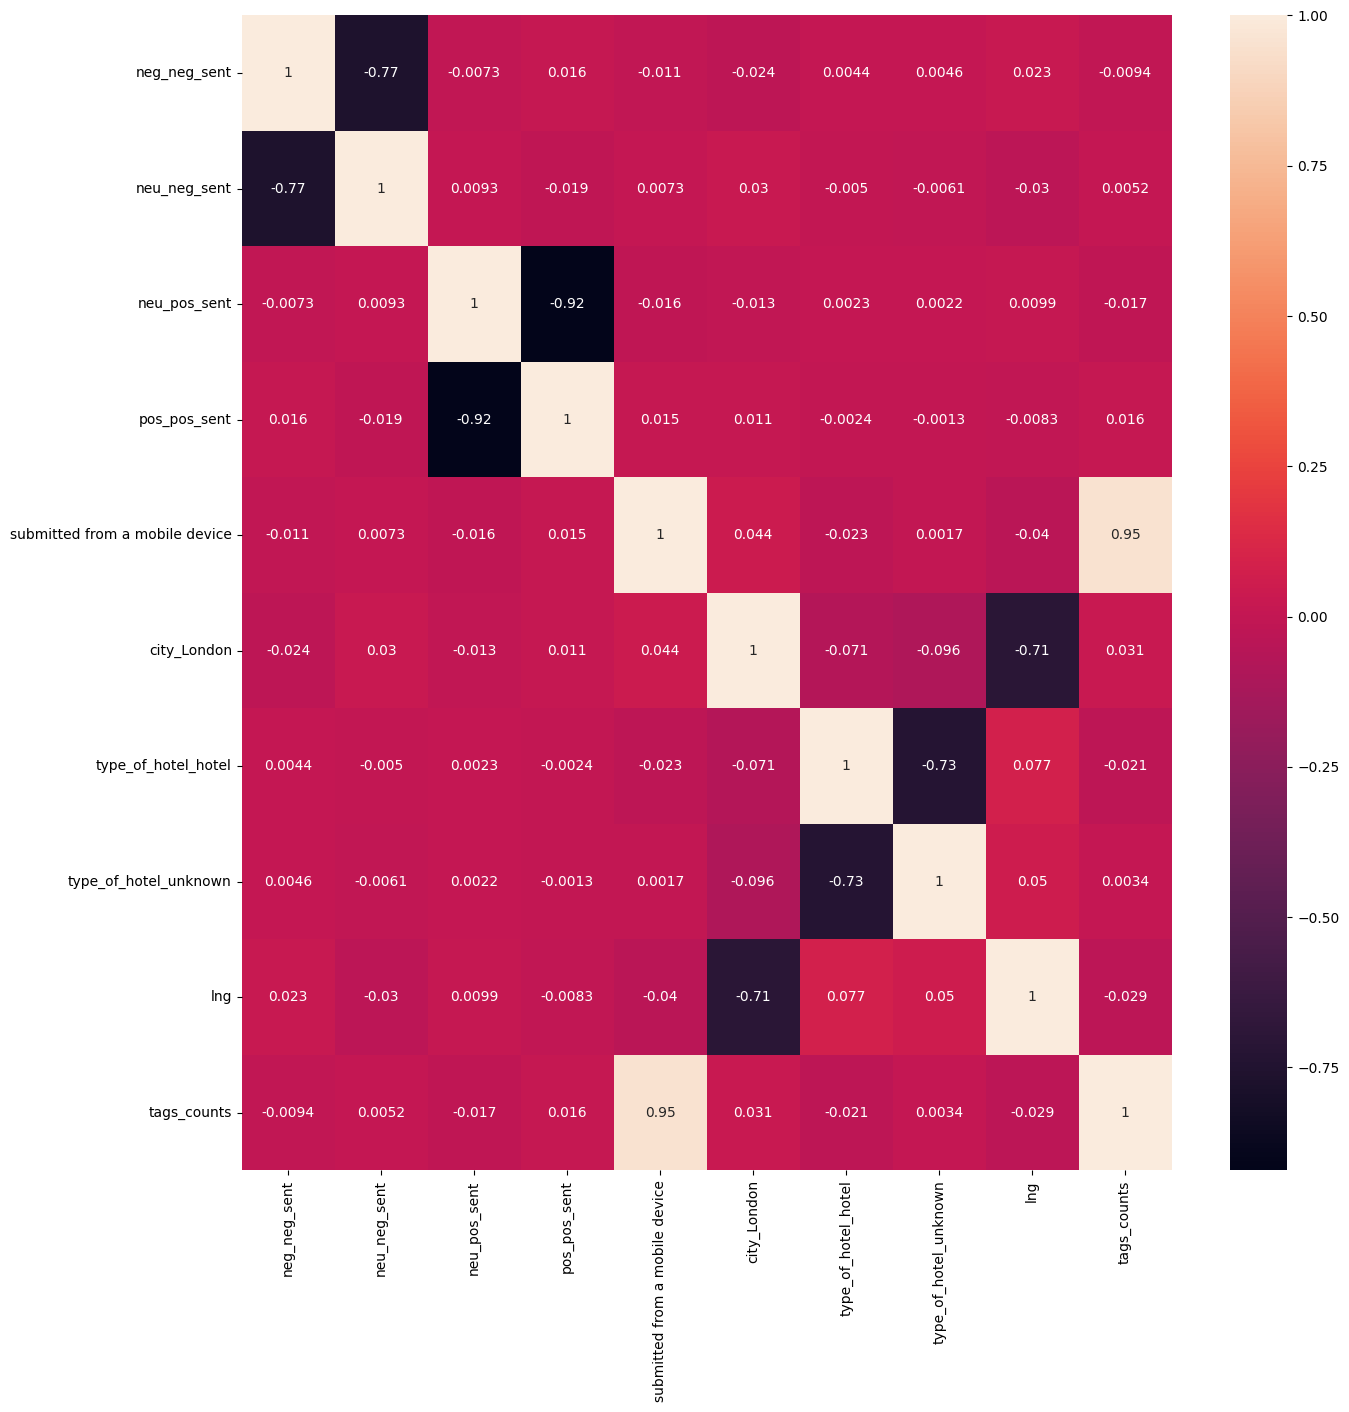

In [ ]:
# т.к. у нас огромное кол-во признаков
# будем отображать только те,
# у которых наблюдается сильная корреляция
hotels_corr = hotels.corr('kendall')

# делаем копию корреляции, чтобы проверять условия
# на данных с обнуленной главной диагональю, при этом
# не обнуляя диагональ у оригинала
corr_copy = hotels_corr.copy()
for i in range(corr_copy.shape[0]):
    corr_copy.iloc[i,i] = 0
    
# удаляем все строки и столбцы, где нет мультиколлинеарности
for feature in hotels_corr.columns:
    if (corr_copy[feature].min() >= -0.7) and (corr_copy[feature].max() <= 0.7):
        hotels_corr = hotels_corr.drop([feature], axis = 0)
        hotels_corr = hotels_corr.drop([feature], axis = 1)

fig, ax = plt.subplots(figsize = (15,15))
sns.heatmap(hotels_corr, annot = True, ax=ax)

plt.show();


Логично, что уровень негатива негативных отзывов 'neg_neg_sent' коррелирует с уровнем нейтрального настроения негативных отзывов 'neu_neg_sent', аналогичная ситуация с признаками полученными из позитивных отзывов, радует, что в матрицу мультиколлинеарных признаков не попали признаки общего настроения отзывов 'compnd_pos_sent' и 'compnd_neg_sent' , а также признаки меры противоположного настроения отзывов 'pos_neg_sent' и 'neg_pos_sent'. 

Непредсказуемо было высокая корреляция признаков 'lng' и 'city_London', 'submitted from a mobile device' и 'tags_counts', а также 'type_of_hotel_unknown' и 'type_of_hotel_hotel'. 

Но прежде чем удалять признаки, посмотрим на значимость каждого признака для целевой переменной — рейтинг отеля.



## Оценка значимости признаков для целевой переменной.

Для оценки значимости категориальных признаков будем использовать тест ***хи-квадрат***, для непрерывных признаков — тест ***ANOVA***.
Для оценки значимости каждого признака для целевой переменной - рейтинг отеля, нам нужно разделить выборку на X и y, то есть на обучаемый датасет и целевой признак.

In [ ]:
df_hotels = hotels[hotels['sample'] == 1] #Возьмём данные с корректными значениями целевого признака
X = df_hotels.drop(['reviewer_score'], axis=1)
y = df_hotels['reviewer_score']

Числовые признаками можно считать список признаков отобранных для нормализации num_cols, однако в этом списке есть несколько категориальных признаков 'lat', 'lng', 'average_score' удалим из списка данные призаки и признак с непрерывными значениями готов.
Осталось определить список категориальных признаков.

In [ ]:
# Удалим из списка num_cols категориальные признаки для получения признаков с непрерывными значениями.
num_cols.remove('lat')
num_cols.remove('lng')
num_cols.remove('average_score')


# Теперь разница между всеми признаками датасета и списком num_cols 
# и будет список категориальных признаков
cat_cols = list(set(X.columns).difference(set(num_cols)))
cat_cols.remove('sample') # удаляем из списка признак метки тренировочного и тестового датасета
print(len(cat_cols))

63


Тест хи-квадрат, реализованный в библиотеке sklearn.feature_selection.chi2 возвращает массив значений хи-квадрат и p-value для каждого признака. Используем только значения хи-квадрат и выведем их на графике:

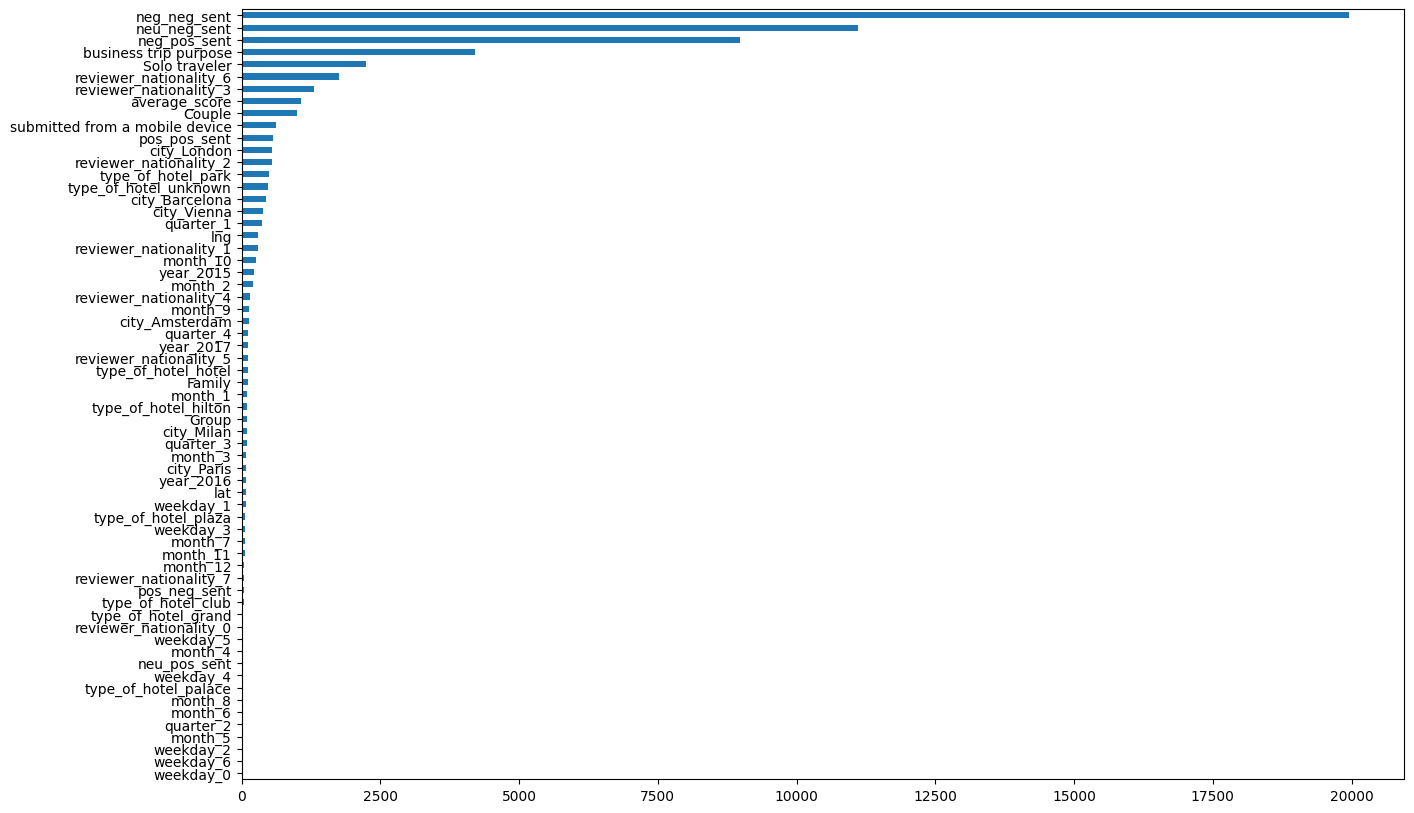

In [ ]:
y=y.astype('int')


from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)

imp_cat.sort_values(inplace = True)

fig, ax = plt.subplots(figsize=(15,10))

imp_cat.plot(kind = 'barh', ax=ax)

plt.show();

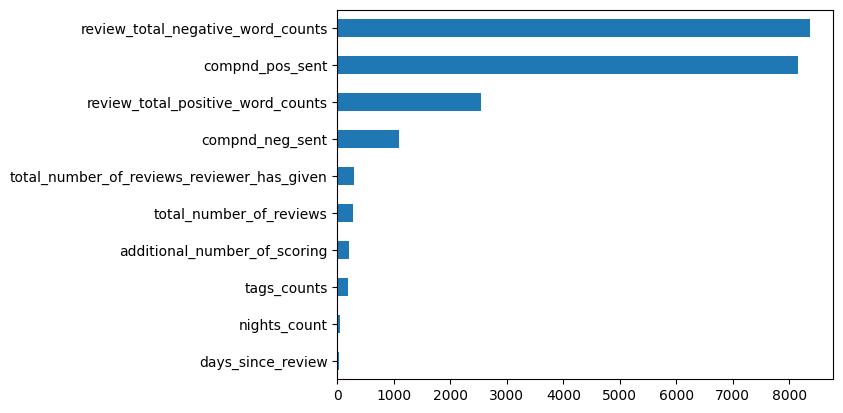

In [ ]:
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh');

На самом деле мы не будем удалять признаки вообще. В процессе разработки проекта было выяснено, что удаление каких-либо признаков из нашего преобразованного датасета только вредило итоговой модели судя по метрике MAPE. С чем это связано не ясно. Мультиколлинеарность и малое влияние признаков совсем не мешает нашей модели.

# Обучение модели и предсказание целевой переменной.

## Предсказание на данных, созданных в блокноте.

Распределяем наш датасет  и целевой признак на тренировочные и тестовые данные.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Обучение и оценка качества модели

In [ ]:
from sklearn.ensemble import RandomForestRegressor # модель Random Forest
from sklearn.metrics import mean_absolute_percentage_error # метрика MAPE

regr = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
regr.fit(X_train, y_train) # Обучение модели

y_pred =  regr.predict(X_test)# предсказание целевого признака

# Метрика Mean Absolute Percentage Error (MAPE) показывает среднюю абсолютную процентную ошибку предсказанных значений в отношении фактических. 
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f'MAPE = {mape}')


MAPE = 0.14837364466843944


## Предсказание на тестовых данных соревнования

In [ ]:
X_test = hotels[hotels['sample'] == 0].drop(['reviewer_score'], axis=1)
display(X_test.shape)

regr = RandomForestRegressor(n_estimators = 100, n_jobs = -1, random_state = 42)
regr.fit(X,y) # Обучение модели

y_pred = regr.predict(X_test) # Предсказание целевого признака

(128935, 74)

In [ ]:
# Посмотрим на данные submission.csv:

submission = pd.read_csv(r'C:\Users\Mira\Desktop\Блок 3. Разведывательный анализ\Соревнование на Kaggle\data\submission.csv')
print(submission.shape)
submission.head()

In [ ]:
# Добавим в submission предсказанные значения рейтингов:

submission['reviewer_score'] = y_pred
submission.to_csv(r'C:\Users\Mira\Desktop\Блок 3. Разведывательный анализ\Соревнование на Kaggle\data\booking_model_submission_mirunchik.csv', index = False)